# This code was inspired by https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/?utm_content=cmp-true#google_vignette

# Necessary Libraries

In [81]:
import matplotlib.pyplot as plt
import nltk #Ensure downloading NLTK
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import contractions
from pprint import pprint 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Pre-processing

In [70]:
# Load the dataset
file_path = 'kay_filtered_lip_products.csv'
df = pd.read_csv(file_path)
processed_docs = df['review_text']

In [86]:
def data_preprocessing(text):
    text = str(text)
    text = contractions.fix(text)  # Expand contractions here
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    tokens = [re.sub(r'[^a-zA-Z\s]', '', token) for token in tokens]  # Remove special characters and digits from each token
    stop_words = set(stopwords.words('english'))
    stop_words.update(['kay', 'lip', 'lips', 'lipstick','eye', 'eyeshadow', 'shadow', 'good'])
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token != '']  # Lemmatize & remove stopwords
    return tokens

In [87]:
processed_docs = df['review_text'].map(data_preprocessing)
processed_docs

0                                   [longlasting, smudge]
1       [love, smell, consistency, hydrating, texture,...
2              [amazing, shade, glide, extremely, smooth]
3       [shade, beautiful, matte, go, product, worth, ...
4       [beautiful, brown, shade, look, super, matte, ...
                              ...                        
2200    [full, matt, shade, different, show, picture, ...
2201    [zero, staying, power, leaf, trace, everything...
2202                               [expected, stay, long]
2203              [color, gud, poor, stay, price, worthy]
2204    [beautiful, nude, shade, looking, like, shown,...
Name: review_text, Length: 2205, dtype: object

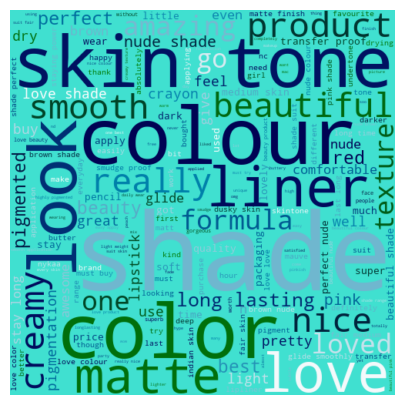

In [112]:
# Combine all processed documents into a single string
words_in_reviews = " ".join([" ".join(doc) for doc in processed_docs])

# Plotting the word cloud
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(width=500, height=500, background_color='#40E0D0', colormap="ocean", random_state=10).generate(words_in_reviews)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [113]:
def lda_experiments(dictionary, corpus, texts, start=3, limit=20, step=1):
    coherence_values = []
    model_list = []
    topic_numbers = range(start, limit + 1, step)

    for num_topics in topic_numbers:
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                         iterations=400, passes=10, random_state=42, per_word_topics=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        print(f"Completed LDA with {num_topics} topics. Coherence score: {coherencemodel.get_coherence()}")

    # Find the model with the highest coherence score
    best_coherence = max(coherence_values)
    best_model_index = coherence_values.index(best_coherence)
    best_model = model_list[best_model_index]

    # Plotting
    plt.figure(figsize=(5, 5))
    plt.plot(topic_numbers, coherence_values, marker='o')
    plt.title('LDA Coherence Score by Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(topic_numbers)
    plt.grid(True)
    plt.show()

    return best_model, best_coherence

# LDA using Unigrams

In [114]:
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

Completed LDA with 3 topics. Coherence score: 0.31665603819604815
Completed LDA with 4 topics. Coherence score: 0.3661643392152347
Completed LDA with 5 topics. Coherence score: 0.3695046633356917
Completed LDA with 6 topics. Coherence score: 0.350096014081367
Completed LDA with 7 topics. Coherence score: 0.3837454757126169
Completed LDA with 8 topics. Coherence score: 0.3729195953788546
Completed LDA with 9 topics. Coherence score: 0.3463419436940583
Completed LDA with 10 topics. Coherence score: 0.36033321502641663
Completed LDA with 11 topics. Coherence score: 0.3806476699762186
Completed LDA with 12 topics. Coherence score: 0.3439043244756636
Completed LDA with 13 topics. Coherence score: 0.3420363047949866
Completed LDA with 14 topics. Coherence score: 0.3330634472198327
Completed LDA with 15 topics. Coherence score: 0.3272659148365202
Completed LDA with 16 topics. Coherence score: 0.3444543991668649
Completed LDA with 17 topics. Coherence score: 0.34857609181849764
Completed LDA w

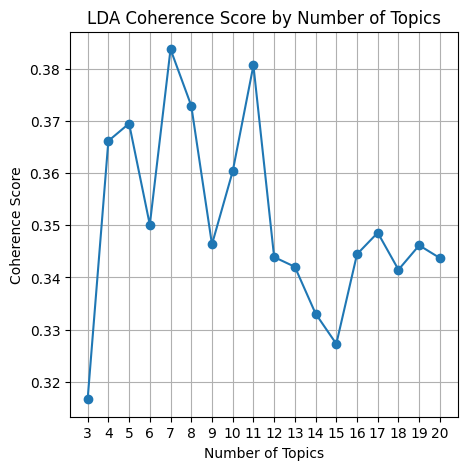

In [115]:
model, coherence = lda_experiments(dictionary=dictionary, corpus=corpus, texts=processed_docs, start=3, limit=20, step=1)

In [98]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model, corpus, dictionary)

# Display the visualization in a Jupyter Notebook
pyLDAvis.display(vis)

In [99]:
from pprint import pprint 

topics = model.print_topics()
for topic in topics:
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.038*"power" + 0.036*"stay" + 0.035*"staying" + 0.025*"long" + 0.025*"colour" + 0.022*"office" + 0.020*"formula" + 0.017*"pencil" + 0.016*"smudgeproof" + 0.016*"costly"
Topic 1: 0.021*"even" + 0.018*"better" + 0.017*"waste" + 0.017*"hour" + 0.016*"price" + 0.015*"money" + 0.015*"product" + 0.012*"proof" + 0.012*"matte" + 0.012*"disappointed"
Topic 2: 0.028*"liner" + 0.024*"shade" + 0.023*"colour" + 0.022*"best" + 0.019*"one" + 0.015*"long" + 0.014*"color" + 0.014*"beautiful" + 0.013*"really" + 0.013*"got"
Topic 3: 0.037*"long" + 0.036*"shade" + 0.027*"texture" + 0.025*"lasting" + 0.024*"smooth" + 0.022*"creamy" + 0.018*"love" + 0.017*"stay" + 0.017*"transfer" + 0.015*"matte"
Topic 4: 0.066*"shade" + 0.022*"colour" + 0.021*"beauty" + 0.015*"red" + 0.015*"beautiful" + 0.014*"matte" + 0.013*"nice" + 0.012*"brown" + 0.012*"crayon" + 0.012*"look"
Topic 5: 0.089*"shade" + 0.043*"skin" + 0.039*"nude" + 0.037*"tone" + 0.026*"perfect" + 0.025*"love" + 0.025*"look" + 0.017*"beautiful" 

In [109]:
dominant_topics = []

for doc_bow in corpus:
    topic_probabilities = model[doc_bow]
    dominant_topic = max(topic_probabilities, key=lambda x: x[1])[0]  # get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Now `dominant_topics` contains the dominant topic index for each document
# map the topic index to more meaningful labels:
topic_labels = {0: "Product Quality", 1: "Product Quality", 2: "Product Quality", 3: "Texture", 4: "Shade", 5: "Skin Tone", 6: "Texture"}  # Map topic indices to labels
labeled_topics = [topic_labels[topic] for topic in dominant_topics]

labeled_topics

df['Dominant_Topic_Label'] = labeled_topics

df.head(50)
df.to_csv('kay_labeled.csv', index=False)

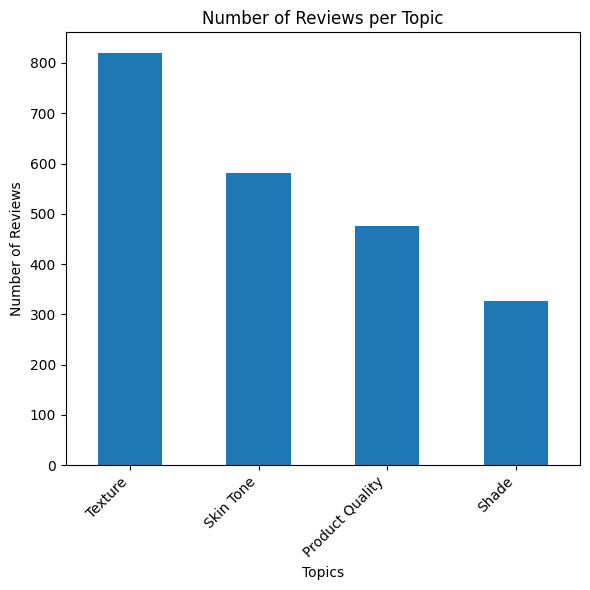

In [116]:
# Count the occurrences of each topic
topic_counts = pd.Series(labeled_topics).value_counts()

# Plotting
plt.figure(figsize=(6, 6))
topic_counts.plot(kind='bar')
plt.title('Number of Reviews per Topic')
plt.xlabel('Topics')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# LDA using Bigrams

In [117]:
bigram = Phrases(processed_docs, min_count=3, threshold=10)
bigram_mod = Phraser(bigram)

# Apply bi-gram model
docs_bigrams = [bigram_mod[doc] for doc in processed_docs]

# Proceed with these documents to create  dictionary and corpus
dictionary_bigrams = Dictionary(docs_bigrams)
corpus_bigrams = [dictionary_bigrams.doc2bow(doc) for doc in docs_bigrams]

Completed LDA with 3 topics. Coherence score: 0.3230305555505675
Completed LDA with 4 topics. Coherence score: 0.28800344478400963
Completed LDA with 5 topics. Coherence score: 0.2942632615647415
Completed LDA with 6 topics. Coherence score: 0.32166907725733523
Completed LDA with 7 topics. Coherence score: 0.3099423154297653
Completed LDA with 8 topics. Coherence score: 0.3320130698441529
Completed LDA with 9 topics. Coherence score: 0.29813856773073943
Completed LDA with 10 topics. Coherence score: 0.3154232521917481
Completed LDA with 11 topics. Coherence score: 0.3142347654181899
Completed LDA with 12 topics. Coherence score: 0.3356074541419208
Completed LDA with 13 topics. Coherence score: 0.3354885054820957
Completed LDA with 14 topics. Coherence score: 0.33069850929638467
Completed LDA with 15 topics. Coherence score: 0.322563532755946
Completed LDA with 16 topics. Coherence score: 0.33111198250170115
Completed LDA with 17 topics. Coherence score: 0.3326865110727251
Completed LDA

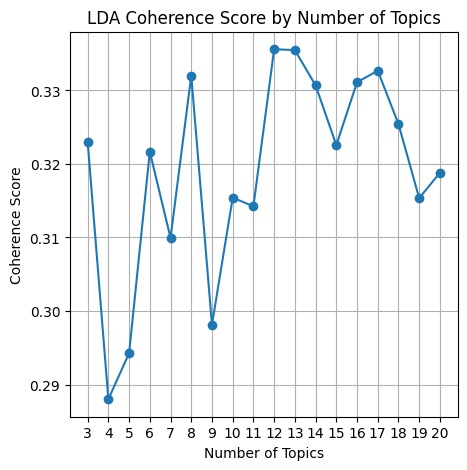

In [118]:
best_model, best_coherence = lda_experiments(dictionary=dictionary_bigrams, corpus=corpus_bigrams, texts=docs_bigrams, start=3, limit=20, step=1)

In [92]:
topics = best_model.print_topics()
for topic in topics:
    print("Topic {}: {}".format(topic[0], topic[1]))

Topic 0: 0.085*"shade" + 0.028*"pretty" + 0.020*"pigment" + 0.020*"n" + 0.019*"product" + 0.017*"price" + 0.015*"work" + 0.015*"similar" + 0.014*"range" + 0.013*"formula"
Topic 1: 0.035*"product" + 0.031*"time" + 0.031*"light" + 0.027*"suit" + 0.027*"got" + 0.025*"love" + 0.025*"sale" + 0.022*"colour" + 0.020*"brown" + 0.019*"wiped"
Topic 2: 0.061*"shade" + 0.036*"one" + 0.027*"brown" + 0.025*"nude" + 0.023*"perfect" + 0.021*"color" + 0.020*"look" + 0.016*"best" + 0.016*"pink" + 0.016*"liner"
Topic 3: 0.047*"creamy" + 0.024*"texture" + 0.022*"dry" + 0.021*"love" + 0.019*"color" + 0.019*"colour" + 0.019*"shade" + 0.016*"matte" + 0.016*"formula" + 0.016*"also"
Topic 4: 0.054*"love" + 0.041*"beauty" + 0.031*"shade" + 0.030*"product" + 0.030*"colour" + 0.029*"much" + 0.026*"one" + 0.017*"liner" + 0.016*"crayon" + 0.016*"texture"
Topic 5: 0.049*"liner" + 0.043*"color" + 0.039*"stay" + 0.029*"beautiful" + 0.023*"bought" + 0.021*"long" + 0.018*"work" + 0.018*"shade" + 0.018*"love" + 0.016*"us

In [93]:
# Ensure you have the latest versions of pyLDAvis and gensim to avoid compatibility issues

# Prepare the visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_model, corpus_bigrams, dictionary_bigrams)

# Display the visualization in a Jupyter Notebook
pyLDAvis.display(vis)

# LDA using Trigrams

In [119]:
bigram = Phrases(processed_docs, min_count=3, threshold=10)
trigram = Phrases(bigram[processed_docs], min_count=3 ,threshold=10)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Apply tri-gram model
docs_trigrams = [trigram_mod[bigram_mod[doc]] for doc in processed_docs]

# Proceed with these documents to create  dictionary and corpus
dictionary_trigrams = Dictionary(docs_trigrams)
corpus_trigrams = [dictionary_trigrams.doc2bow(doc) for doc in docs_trigrams]

Completed LDA with 3 topics. Coherence score: 0.34492595556311545
Completed LDA with 4 topics. Coherence score: 0.32436054660722324
Completed LDA with 5 topics. Coherence score: 0.32564643223212286
Completed LDA with 6 topics. Coherence score: 0.3175421137360086
Completed LDA with 7 topics. Coherence score: 0.35743052506435663
Completed LDA with 8 topics. Coherence score: 0.32879456728166534
Completed LDA with 9 topics. Coherence score: 0.34311526929667147
Completed LDA with 10 topics. Coherence score: 0.32517450510617385
Completed LDA with 11 topics. Coherence score: 0.3176546283954561
Completed LDA with 12 topics. Coherence score: 0.31692499656669215
Completed LDA with 13 topics. Coherence score: 0.34813678899656275
Completed LDA with 14 topics. Coherence score: 0.31104808069322354
Completed LDA with 15 topics. Coherence score: 0.32991162482532727
Completed LDA with 16 topics. Coherence score: 0.3070088085420466
Completed LDA with 17 topics. Coherence score: 0.31709022748466087
Compl

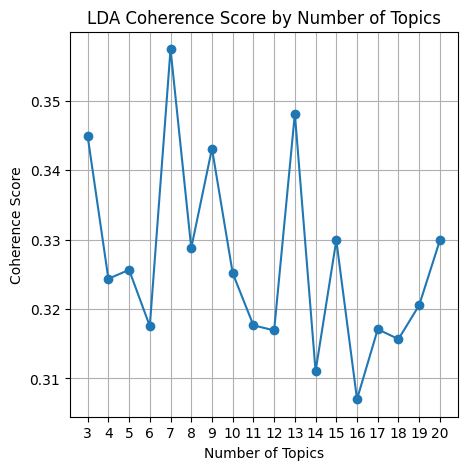

In [120]:
trigrams_model, trigrams_coherence = lda_experiments(dictionary=dictionary_trigrams, corpus=corpus_trigrams, texts=docs_trigrams, start=3, limit=20, step=1)

In [102]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# Ensure you have the latest versions of pyLDAvis and gensim to avoid compatibility issues

# Prepare the visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(trigrams_model, corpus_trigrams, dictionary_trigrams)

# Display the visualization in a Jupyter Notebook
pyLDAvis.display(vis)